# Genetic algorithm for the Traveling Salesman Problem
This project is an implementation of a genetic algorithm to approximate a solution to the Traveling Salesman Problem. A genetic algorithm draws inspiration from the thoery of evolution by maintainig a set of possible solutions (the population) and applying successive reproduction, mutation, and selection steps to approximate a solution by optimising a given fitness function. This project is informed by the book [Introduction to Evolutionary Computing](http://www.evolutionarycomputation.org/).

## Dependencies

In [8]:
# Import libraries
import matplotlib.pyplot as plt
import random
import numpy as np
import math
import matplotlib.animation as animation
from IPython.display import HTML # For displaying matplotlib animations in google colab.
from matplotlib.patches import FancyArrowPatch, Rectangle # For array representations.

##Problem definition

The TSP consists in finding the shortest route to visit N cities and return to the starting city. The first step of a genetic algorithm is to define a representation for a possible solution. The goal here is usually to code a solution in a way that is both memory efficient and that allows for an easy implementation of the successive steps of the algorithm. The routes will be represented as permutations, with the values of the permutation corresponding to the index of a city.

In [9]:
# Generates random coordinates for a city between (0,0) and (width, height).
def generate_city(width, height):
  return (random.randrange(width), random.randrange(height))

# Generates N random cities.
def generate_cities(N, width, height):
  return [generate_city(width, height) for i in range(N)]

# Returns the squared distance separating two cities
def distance(city1, city2):
  return math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

# Returns a square matrix containing the squared distances between cities.
# matrix[i][j] is the squared distance between the i-th city and the j-th city.
def compute_distances(cities):
  N = len(cities)
  distances = [ [0 for j in range(N)] for i in range(N)]
  for i in range(N):
    for j in range(i, N):
      dist = distance(cities[i], cities[j])
      distances[i][j] = dist
      distances[j][i] = dist
  return distances

### Problem parameters

In [10]:
WIDTH = 20
HEIGHT = 20
N = 20
CITIES = generate_cities(N, WIDTH, HEIGHT)
DISTANCES = compute_distances(CITIES)


The following code is used to display an individual route using a scatter plot.

In [11]:
# Plots the cities on a scatter plot.
def plot_cities(cities):
  x_coords, y_coords = list(zip(*cities))
  plt.scatter(x_coords, y_coords)

# Plots the route.
def plot_route(cities, permutation):
  x_coords = [cities[i][0] for i in permutation]
  x_coords.append(x_coords[0]) # Go back to initial city at the end of the route.
  y_coords = [cities[i][1] for i in permutation]
  y_coords.append(y_coords[0])
  plt.plot(x_coords, y_coords, linestyle='-', marker='o', color='b')

def display_route(cities, permutation):
  plot_cities(cities)
  plot_route(cities, permutation)
  plt.axis('off')
  plt.show()

### Example route

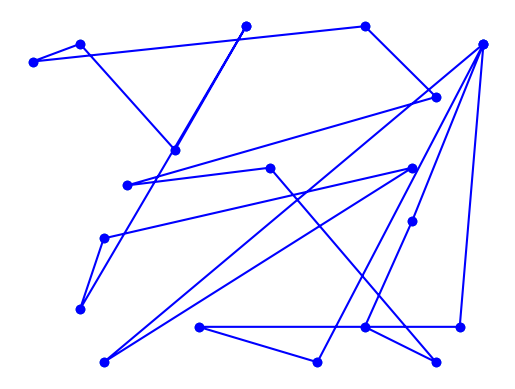

In [12]:
display_route(CITIES, random.sample(range(N), N))

## Fitness function

This function will be used to compare individual solutions and inform the selection steps. In this case, the fitness function simply computes the length of a given route and returns the inverse.

In [13]:
def compute_inverse_route_length(permutation):
  length = 0
  for i in range(len(permutation) - 1):
    length += DISTANCES[permutation[i]][permutation[i+1]]
  return 1/length

## Array visualisation code

Used to draw a figure of the contents of an array. Used for the examples below.

In [14]:
def draw_array(ax, array, colored=[]):
  for i, val in enumerate(array):
    rect = Rectangle((i, 0), 1, 1, fill= True if i in colored else False, edgecolor='black')
    ax.add_patch(rect)
    ax.text(i + 0.5, 0.5, str(val), ha='center', va='center', fontsize=14)
  ax.set_xlim(0, len(array))
  ax.set_ylim(0, 1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_aspect('equal')

## Mutation

Mutations are one of the two variation operators used to explore the space of possible solutions. It works by making small random changes to the existing candidate solutions. However, since we are using a permutation representation, the changes can't be completely random, as the solution needs to remain a valid permutation after the mutation. The inversion mutation works by selecting two random positions in the permutation string and reversing the given substring. This maintains a valid permutation and only changes two links in the route.  

In [15]:
def generate_substring_ends(N):
  start = random.randrange(N)
  end = random.randrange(N)
  # Ensure start != end.
  while end == start:
    end = random.randrange(N)
  if start > end:
    start, end = end, start
  return (start, end)

# Mutation function
def inversion_mutation(permutation, return_inverted_segment=False):
  N = len(permutation)
  start, end = generate_substring_ends(N)
  reversed = permutation[start:end]
  reversed.reverse()
  if return_inverted_segment:
    return (permutation[0:start] + reversed + permutation[end:], (start, end))
  return permutation[0:start] + reversed + permutation[end:]

### Inversion mutation example

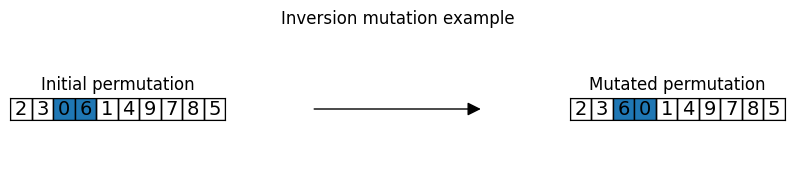

In [16]:
test_permutation = random.sample(range(10), 10)
mutated_permutation, segment = inversion_mutation(test_permutation, True)
mutated_values = range(segment[0], segment[1])

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')

# Draw initial permutation.
ax1 = fig.add_subplot(1, 3, 1)
draw_array(ax1, test_permutation, mutated_values)
ax1.set_title("Initial permutation")

# Draw the arrow.
ax2 = fig.add_subplot(1,3,2)
ax2.axis('off')
arrow = FancyArrowPatch((0.1, 0.5), (0.9, 0.5), mutation_scale=20, color="black", arrowstyle='-|>')
ax2.add_patch(arrow)

# Draw mutated permutation.
ax3 = fig.add_subplot(1, 3, 3)
draw_array(ax3, mutated_permutation, mutated_values)
ax3.set_title("Mutated permutation")

# Adjust layout
ax.set_title("Inversion mutation example")
plt.subplots_adjust(wspace=0.3)
plt.show()

## Recombination

The second variation operator is recombination. It creates new solutions by combining two existing solutions.

The Partially Mapped Crossover (PMX) creates two offsprings from two parent solutions. First, two crossover points are chosen at random. Then, the delimited segment is copied into the first offspring. The values from the second parents outside of the delimited segment are copied into the offspring. If a value was already copied, then the first value from the segment of the second parent that is not contained in the segment from the first is copied in its place. The same procedure is used for the second offspring but with the parents reversed.

In [17]:
# Creates two offsprings from the recombination of the given permutations.
def partially_mapped_crossover(permutation1, permutation2, return_crossover_segment=False):
  N = len(permutation1)
  start, end = generate_substring_ends(N)
  def generate_offspring(parent1, parent2):
    segment1 = parent1[start: end]
    segment2 = parent2[start: end]
    remaining_values = list(set(segment2) - set(segment1))
    offspring = []
    remaining_values_copied = 0

    for i in range(N):
      if start <= i < end:
        offspring.append(segment1[i - start])
      elif parent2[i] not in segment1:
        offspring.append(parent2[i])
      else:
        offspring.append(remaining_values[remaining_values_copied])
        remaining_values_copied += 1

    return offspring
  if return_crossover_segment:
    return ((generate_offspring(permutation1, permutation2), generate_offspring(permutation2, permutation1)), (start,end))
  return (generate_offspring(permutation1, permutation2), generate_offspring(permutation2, permutation1))

### Partially-mapped crossover example

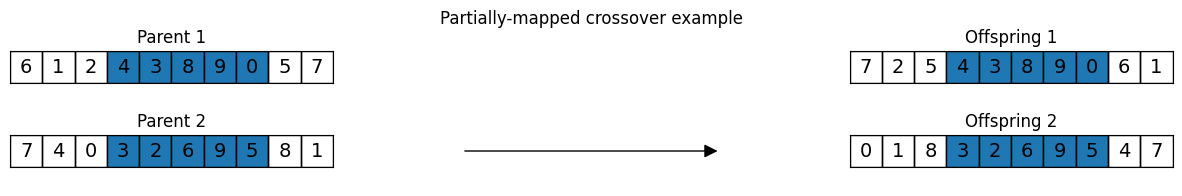

In [18]:
example_size = 10
parent1 = random.sample(range(example_size), example_size)
parent2 = random.sample(range(example_size), example_size)
childs, segment = partially_mapped_crossover(parent1, parent2, return_crossover_segment=True)
child1, child2 = childs
segment_values = range(segment[0], segment[1])

fig, ax = plt.subplots(figsize=(15, 2))
ax.axis('off')

# Draw parent1
ax1 = fig.add_subplot(2, 3, 1)
draw_array(ax1, parent1, segment_values)
ax1.set_title("Parent 1")

# Draw parent2
ax2 = fig.add_subplot(2, 3, 4)
draw_array(ax2, parent2, segment_values)
ax2.set_title("Parent 2")

# Draw the arrow.
ax3 = fig.add_subplot(2,3,5)
ax3.axis('off')
arrow = FancyArrowPatch((0.1, 0.5), (0.9, 0.5), mutation_scale=20, color="black", arrowstyle='-|>')
ax3.add_patch(arrow)

# Draw child1.
ax4 = fig.add_subplot(2, 3, 3)
draw_array(ax4, child1, segment_values)
ax4.set_title("Offspring 1")

# Draw child2.
ax5 = fig.add_subplot(2, 3, 6)
draw_array(ax5, child2, segment_values)
ax5.set_title("Offspring 2")

# Adjust layout
ax.set_title("Partially-mapped crossover example")
plt.subplots_adjust(wspace=0.3)
plt.show()

## Parent selection

The algorithm needs to define some sort of selection for the individuals that are to be recombined. This will pressure the individuals solution to be fit, ultimately driving improvement in the fitness of the population.  

### Ranking selection

The ranking selection ranks the individual solutions by fitness and assigns a higher probability to be selected to the higher ranked individuals. The mapping from ranks to probabilities used is linear:

$$P_{lin}(i) = \frac{2-s}{\mu} + \frac{2i(s-1)}{\mu(\mu-1)}$$

where the parameter s $(1 < s \leq 2)$ influences the selection pressure and i is the rank of the individual (starting from 0).

Other mappings can be used, such as an exponential mapping for higher selection pressure.

In [19]:
# Returns a mating pool.
def ranking_selection(population, fitness_function, mapping, return_cdf=False):
  mu = len(population)
  population.sort(key=fitness_function) # Should be optimized to avoid repeatedly computing fitness.
  cdf = [0]
  for i in range(1, mu):
    cdf.append(mapping(mu, 2, i) + cdf[i-1])
  if return_cdf:
    return (sample_from_cdf(population, cdf, mu), cdf)
  return sample_from_cdf(population, cdf, mu)

def sample_from_cdf(population, cdf, sample_size):
  random_numbers = np.random.uniform(0, 1, sample_size)
  sample_indices = np.searchsorted(cdf, random_numbers)
  return [population[i] for i in sample_indices]

def linear_mapping(mu, s, rank):
  return (2-s)/mu + (2*rank*(s-1)/(mu*(mu-1)))

### Visualisation of parent distribution

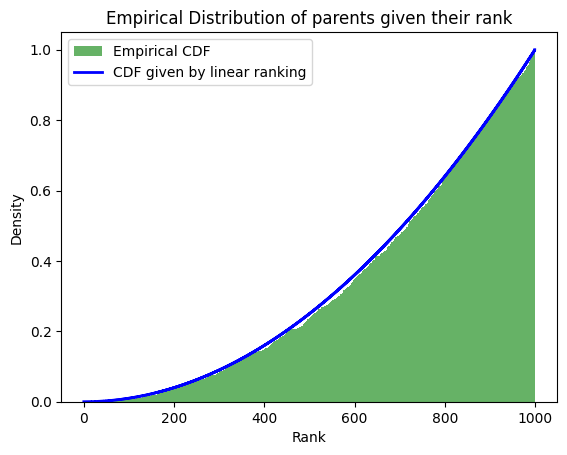

In [31]:
test_population = [random.sample(range(N), N) for i in range(1000)]
test_mating_pool, test_cdf = ranking_selection(test_population, compute_inverse_route_length, linear_mapping, return_cdf=True)
test_indices = [test_population.index(test_mating_pool[i]) for i in range(len(test_mating_pool))]
plt.hist(test_indices, bins=1000, density=True, alpha=0.6, color='g', cumulative=True, label='Empirical CDF')
plt.step(range(1000), test_cdf, where='post', color='blue', label='CDF given by linear ranking', linewidth=2)
plt.xlabel('Rank')
plt.ylabel('Density')
plt.title('Empirical Distribution of parents given their rank')
plt.legend()
plt.show()

## Simple genetic algorithm

The steps defined above are sufficient to implement a simple genetic algorithm. However, the numeric parameters of the algorithm, namely the population size, the maximum number of generations, and the mutation rate remain to be chosen. For this matter, multiple runs of the algorithm with varying, arbitrarly chosen values for the parameters will be compared by plotting the evolution of the maximum fitness by generation. The maximum number of generations is set to 200 for all runs and population sizes of 500, 1000, and 2000 will be paired with mutation rates of 1%, 5%, and 10%.



In [36]:
def simple_genetic_algorithm(population_size, max_generations, fitness_function, mutation, mutation_probability, recombination, parent_selection):

  #Initialize population.
  population = [random.sample(range(N), N) for i in range(population_size)]
  best_solutions = []
  best_solutions_fitness = []
  best_solution = None
  best_solution_fitness = 0
  for i in range(max_generations):
    mating_pool = parent_selection(population, fitness_function, linear_mapping)
    # Generate offsprings by recombination.
    offsprings = []
    for j in range(0, population_size, 2):
      offsprings.extend(recombination(mating_pool[j], mating_pool[j+1]))
    # Mutate offsprings.
    for j in range(population_size):
      random_number = np.random.uniform(0,1)
      if random_number <= mutation_probability:
        offsprings[j] = mutation(offsprings[j])
    # Replace population by offsprings.
    population = offsprings
    # Record fittest individual.
    current_best = max(population, key=fitness_function)
    current_best_fitness = fitness_function(current_best)
    if current_best_fitness > best_solution_fitness:
      best_solution = current_best
      best_solution_fitness = current_best_fitness
    best_solutions.append(best_solution)
    best_solutions_fitness.append(best_solution_fitness)
  # Return best solution after set amout of generations.
  return {
      "best_solution": best_solution,
      "best_solution_fitness": best_solution_fitness,
      "best_solutions": best_solutions,
      "best_solutions_fitness": best_solutions_fitness
  }

### Comparing parameters

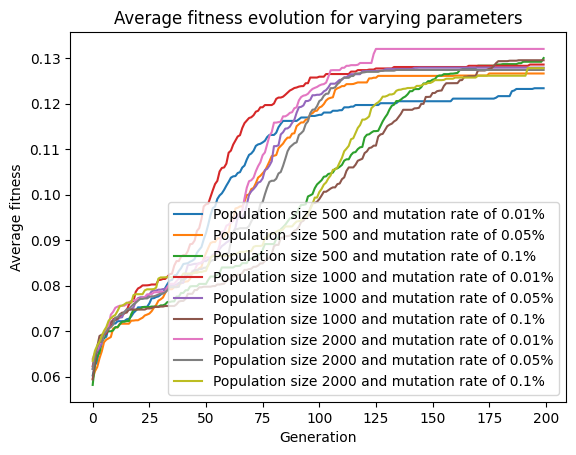

In [42]:
test_population_sizes = [500, 1000, 2000]
test_mutation_probabilities = [0.01, 0.05, 0.1]
for population_size in test_population_sizes:
  for mutation_probability in test_mutation_probabilities:
    average_fitness_by_generation = [0 for i in range(200)]
    samples = 10
    for i in range(samples):
      test_summary = simple_genetic_algorithm(population_size, 200,
        compute_inverse_route_length, inversion_mutation, mutation_probability, partially_mapped_crossover, ranking_selection)
      average_fitness_by_generation = np.add(average_fitness_by_generation, test_summary["best_solutions_fitness"])
    average_fitness_by_generation / samples
    plt.plot(range(200), average_fitness_by_generation, linestyle='-',
            label=f'Population size {population_size} and mutation rate of {mutation_probability}%')
plt.xlabel('Generation')
plt.ylabel('Average fitness')
plt.title('Average fitness evolution for varying parameters')
plt.legend()
plt.show()

The results seem to suggest that lower mutation rates converge faster while no significant difference is observed for varying population sizes for this problem size. The number of maximum generations can also be lowered as most runs start converging as soon as 125 generations. A choice of a population size of 500 with a mutation rate of 1% should lead to fast approximate solutions. Further testing would be required for optimal parameter tuning.

### Animation code

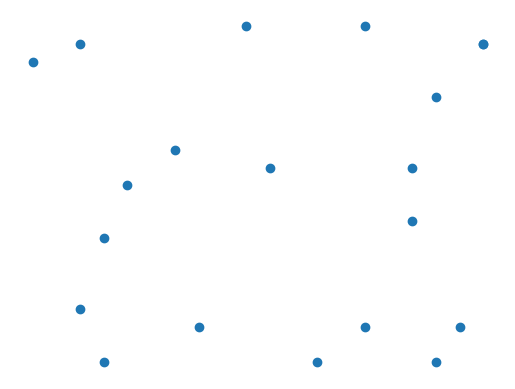

In [44]:
summary = simple_genetic_algorithm(500, 150, compute_inverse_route_length, inversion_mutation, 0.01, partially_mapped_crossover, ranking_selection)
solutions = summary["best_solutions"]

# Create a figure and axis
fig, ax = plt.subplots()

# Initialize the plot
def init():
    ax.clear()
    x_coords, y_coords = list(zip(*CITIES))
    ax.scatter(x_coords, y_coords)
    ax.axis('off')
    ax.grid(True)

# Update the plot for each frame
def update(frame):
    init()
    tour = solutions[frame]
    x_coords = [CITIES[i][0] for i in tour]
    x_coords.append(x_coords[0]) # Go back to initial city at the end of the route.
    y_coords = [CITIES[i][1] for i in tour]
    y_coords.append(y_coords[0])
    ax.plot(x_coords, y_coords, linestyle='-', marker='o', color='b')
    ax.set_title(f"Best solution found after {frame + 1} generations")

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(solutions), init_func=init, blit=False, repeat=True)

# Display the animation in the notebook
HTML(ani.to_jshtml())